<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/ModelRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install firebase-admin
from google.colab import drive 
drive.mount('/content/drive')
import firebase_admin
import cv2 
from firebase_admin import credentials,db 
from google.colab.patches import cv2_imshow
from sklearn.externals import joblib 
from firebase_admin import storage 
import pandas as pd 
import csv 
import json
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_predict, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor

     |████████████████████████████████| 71kB 2.5MB/s 
     |████████████████████████████████| 286kB 6.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/36/bd/5f/dbbee4f2d51f97ecd12a363f870361179cb1fd4bc1174ea08a
Successfully built cachecontrol


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
cred = credentials.Certificate("credentials.json")

# Initialize the app with a service account, granting admin privileges
app = firebase_admin.initialize_app(cred, {
    'storageBucket': 'fir-4ca2c.appspot.com',
}, name='storage')

IMAGE GENERATION 

In [4]:
!unzip '/content/drive/My Drive/shanghai.zip'

Archive:  /content/drive/My Drive/shanghai.zip
  inflating: 201405071100.jpg        
  inflating: 201405071200.jpg        
  inflating: 201405071230.jpg        
  inflating: 201405071300.jpg        
  inflating: 201405071330.jpg        
  inflating: 201405081030.jpg        
  inflating: 201405081130.jpg        
  inflating: 201405081200.jpg        
  inflating: 201405081230.jpg        
  inflating: 201405081300.jpg        
  inflating: 201405081330.jpg        
  inflating: 201405081400.jpg        
  inflating: 201405091000.jpg        
  inflating: 201405091100.jpg        
  inflating: 201405091130.jpg        
  inflating: 201405091300.jpg        
  inflating: 201405091430.jpg        
  inflating: 201405101000.jpg        
  inflating: 201405101030.jpg        
  inflating: 201405101100.jpg        
  inflating: 201405101130.jpg        
  inflating: 201405101200.jpg        
  inflating: 201405101330.jpg        
  inflating: 201405101430.jpg        
  inflating: 201405101500.jpg        
  i

In [8]:
##GETTING NAMES  -- ##Location - SSCB and DTU : Rotated images  

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

#blobs is an interator :google.api_core.page_iterator.HTTPIterator object at 0x7f2cd11c84e0>

imglenovo = [] #has all the lenovo images by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:16]=="lenovoinS" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
      blob.download_to_filename('/content/' + "lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')
      imglenovo.append("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg') 
      #print("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')
      ctr+=1
      print(ctr)
      
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
##READING THEM 

dtu=[]
sscb=[]
for img in imglenovo:
  if(img[11:16]>'07-02'):##These indicate the DTU Images - which need to be cropped and rotated 
    l=[]
    l.append(img)
    im = cv2.imread(img)
    crop = im[700:3150, 0:3120]
    crop = cv2.resize(crop, (int(np.shape(im)[1]*0.1), int(np.shape(im)[0]*0.1)))
    im = cv2.resize(crop,(256,256))
    im = cv2.rotate(im,rotateCode =cv2.ROTATE_90_COUNTERCLOCKWISE)
    l.append(im)
    dtu.append(l)
  else:
    l=[]
    l.append(img)
    im = cv2.imread(img)           ##These indicate the SSCB Images - rotation only 
    im = cv2.resize(im, (256,256))
    im = cv2.rotate(im,rotateCode =cv2.ROTATE_90_CLOCKWISE)
    l.append(im)
    sscb.append(l)
    
    
    

In [10]:
## CHECKING BLOCK 

print(len(dtu))
print(len(sscb))


369
502


In [11]:
##GETTING NAMES - PUNJABI BAGH 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgpb = [] #has all the minote pictures by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name.split('/')[1]=="rivers.jpg" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        blob.download_to_filename('/content/' + "pb" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgpb.append("pb" + str(blob.name.split('/')[-1])+ '.jpeg') 
        #print("pb" + str(blob.name.split('/')[-1])+ '.jpeg')
        ctr+=1
        print(ctr)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
##READING IMAGES - Rotated

pb=[]
for img in imgpb:
  l=[]
  l.append(img)
  im = cv2.imread(img)
  im = cv2.resize(im, (256,256))
  im = cv2.rotate(im,rotateCode =cv2.ROTATE_90_CLOCKWISE)
  l.append(im)
  pb.append(l)


In [13]:
##GETTING NAMES - Location : DTU AND SHADIPUR 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgminote = [] #has all the minote pictures by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:16]=="minoteSSC" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        blob.download_to_filename('/content/' + "minote" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgminote.append("minote" + str(blob.name.split('/')[-1])+ '.jpeg') 
        #print("minote" + str(blob.name.split('/')[-1])+ '.jpeg')
        ctr+=1
        print(ctr)
      


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
##READING IMAGES - Location - SSCB and SHADIPUR ; Rotation 
shadipur = []
for img in imgminote : 
  if(img[11:16]>'07-05'):  ##Shadipur images needed rotating  
    l=[]
    l.append(img)
    im = cv2.imread(img)
    im = cv2.resize(im, (256,256))
    im = cv2.rotate(im, rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE)
    l.append(im)
    shadipur.append(l)
  else:
    l=[]
    l.append(img)
    im = cv2.imread(img)               ##SSCB images did not need any rotating 
    im = cv2.resize(im, (256,256))
    l.append(im)
    sscb.append(l)
    

In [15]:
print(len(shadipur))
print(len(sscb))

244
1320


In [16]:


bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

#blobs is an interator :google.api_core.page_iterator.HTTPIterator object at 0x7f2cd11c84e0>

imgito = [] #has all the lenovo images by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:17]=="Lenovo.JPG" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
      blob.download_to_filename('/content/' + "ito" + str(blob.name.split('/')[-1])+ '.jpeg')
      imgito.append("ito" + str(blob.name.split('/')[-1])+ '.jpeg') 
      #print("ito" + str(blob.name.split('/')[-1])+ '.jpeg')
      ctr+=1
      print(ctr)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
##READING BLOCK 

ito=[]

for img in imgito:
  l=[]
  l.append(img)
  im = cv2.imread(img)
  im = cv2.resize(im,(256,256))
  im = cv2.rotate(im, rotateCode = cv2.ROTATE_90_COUNTERCLOCKWISE)
  l.append(im)
  ito.append(l)


In [22]:
## Concatenating Shanghai's data 
import os


shanghai={}
ctr=0
source = os.listdir('/content/')



for file in source:
  if(file[:4]=='2014'):
    im = cv2.imread('/content/' + file)
    im = cv2.resize(im,(256,256))
    l=[]
    l.append(file[8:10])
    l.append(trans_deg(im))
    l.append(entropy(im))
    l.append(contrast(im))
    shanghai[file]=l
    ctr+=1
    print(ctr)
    
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [23]:

print(np.shape(sscb))    
print(np.shape(ito))      
print(np.shape(dtu))  
print(np.shape(shadipur))     
print(np.shape(pb))   
print(len(shanghai))


(1320, 2)
(499, 2)
(369, 2)
(244, 2)
(483, 2)
1953


LABEL PROCESSING 

In [0]:
##SSCB 
df = pd.read_csv('/content/sscb_labels.csv')
data = df.mask(df.eq('None')).dropna()
file = data.to_csv('/content/sscb_labels_new.csv')

k=0
cpcb=[]

with open('/content/sscb_labels_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      cpcb.append(l) 

In [25]:
print(len(cpcb))

698


In [0]:
##TIMESTAMP MODIFICATION 
m_tmp=[]
for tmp in sscb:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l)  
  
  

In [0]:
feat=[]
for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      im = date[2]
#       imc = date[2]
#       imc = cv2.resize(imc, (64,64))
      l=[]
      l.append(val[0])
      l.append(trans_deg(im))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      #print('   -   -  ' + str(l))
      feat.append(l)
      
   

In [28]:
print(len(feat))

1157


In [0]:

df = pd.read_csv('/content/dtu_labels.csv')
data = df.mask(df.eq('None')).dropna()
file = data.to_csv('/content/dtu_labels_new.csv')
k=0
cpcb=[]
with open('/content/dtu_labels_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      cpcb.append(l) 

In [0]:
##TIMESTAMP MODIFICATION 


m_tmp=[]
for tmp in dtu:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l)  
  

In [31]:

for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      print(date[0])
      im = date[2]
      l=[]
#       imc = date[2]
#       imc = cv2.resize(imc, (64,64))
      l.append(val[0])
      l.append(trans_deg(im))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      #print('   -   -  ' + str(l))
      feat.append(l)
      

lenovo2019-07-03 16:54:58.jpeg
lenovo2019-07-03 16:09:45.jpeg
lenovo2019-07-03 16:14:59.jpeg
lenovo2019-07-03 16:20:22.jpeg
lenovo2019-07-03 16:25:16.jpeg
lenovo2019-07-03 16:30:07.jpeg
lenovo2019-07-03 16:37:18.jpeg
lenovo2019-07-03 16:43:24.jpeg
lenovo2019-07-03 16:45:07.jpeg
lenovo2019-07-03 16:50:26.jpeg
lenovo2019-07-03 17:00:01.jpeg
lenovo2019-07-03 17:05:08.jpeg
lenovo2019-07-03 17:55:23.jpeg
lenovo2019-07-03 17:10:40.jpeg
lenovo2019-07-03 17:15:08.jpeg
lenovo2019-07-03 17:19:45.jpeg
lenovo2019-07-03 17:25:15.jpeg
lenovo2019-07-03 17:30:07.jpeg
lenovo2019-07-03 17:37:26.jpeg
lenovo2019-07-03 17:39:45.jpeg
lenovo2019-07-03 17:44:45.jpeg
lenovo2019-07-03 17:50:23.jpeg
lenovo2019-07-03 18:01:07.jpeg
lenovo2019-07-03 18:05:27.jpeg
lenovo2019-07-03 18:55:23.jpeg
lenovo2019-07-03 18:59:45.jpeg
lenovo2019-07-03 18:09:45.jpeg
lenovo2019-07-03 18:15:07.jpeg
lenovo2019-07-03 18:19:45.jpeg
lenovo2019-07-03 18:27:48.jpeg
lenovo2019-07-03 18:29:45.jpeg
lenovo2019-07-03 18:37:20.jpeg
lenovo20

In [32]:

print(len(feat))

1526


In [0]:
## PUNJABI BAGH 

df = pd.read_csv('/content/pb_labels.csv')
data = df.mask(df.eq('None')).dropna()
file = data.to_csv('/content/labels_pb_new.csv')


k=0
cpcb=[]

with open('/content/labels_pb_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      cpcb.append(l) 

In [0]:
##TIMESTAMP MODIFICATION 

m_tmp=[]
for tmp in pb:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l)   

In [0]:
for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      #print(date[0])
      im = date[2]
      l=[]
      l.append(val[0])
#       imc = date[2]
#       imc = cv2.resize(imc,(64,64))
      #l.append(transmission(im,retMean=True))
      l.append(trans_deg(im))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      #print('   -   -  ' + str(l))
      feat.append(l)

In [0]:

print(len(feat))

In [0]:

## SHADIPUR 

df_ = pd.read_csv('/content/shadipur_labels.csv')
data_ = df_.mask(df_.eq('None')).dropna()
file_ = data_.to_csv('/content/shadipur_labels_new.csv')


k=0
cpcb=[]

with open('/content/shadipur_labels_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      cpcb.append(l) 

In [0]:

##TIMESTAMP MODIFICATION 
m_tmp=[]
for tmp in shadipur:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l) 
 

In [0]:

for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      #print(date[0])
      im = date[2]
      l=[]
      l.append(val[0])
      l.append(trans_deg(im))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      #print('   -   -  ' + str(l))
      feat.append(l)

In [0]:
# ITO 
df_ = pd.read_csv('/content/ito_labels.csv')
data_ = df_.mask(df_.eq('None')).dropna()
file_ = data_.to_csv('/content/ito_labels_new.csv')


k=0
cpcb=[]

with open('/content/ito_labels_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>3):
      l=[]
      l.append(row[1]) #DATE 
      l.append(row[3]) #PM
      cpcb.append(l) 

In [0]:
#TIMESTAMP MODIFICATION 
m_tmp=[]
for tmp in ito:
  l=[]
  temp=tmp[0]
  temp=temp[-24:-5]
  temp=temp.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  l.append(tmp[0])
  l.append(final)
  l.append(tmp[1])
  m_tmp.append(l) 

In [0]:
ito_tomatch=[]
for val in cpcb:
  for date in m_tmp:
    if(val[0] == date[1]):
      #print(date[0])
      im = date[2]
      l=[]
      l.append(val[0])
      l.append(trans_deg(im))
      l.append(entropy(im))
      l.append(contrast(im))
      l.append(val[1])
      ito_tomatch.append(l)

In [0]:
print(len(feat))

Till here the feat for all 5 delhi locations is done 
now combining the shanghai data LABELS 


In [0]:
new_shanghai=[]



for key in shanghai:
  temp = key
  temp = temp[6:8] + '-' + temp[4:6] + '-' + temp[0:4] + ' ' + temp[8:10] + ':' + '00'
  #temp = temp[6:8] + '-' + temp[4:6] + '-' + temp[0:4] + ' ' + temp[8:10] + ':' + temp[10:12]
  l=[]
  l.append(temp)
  l.append(shanghai[key][1])
  l.append(shanghai[key][2])
  l.append(shanghai[key][3])
  new_shanghai.append(l)
  

In [0]:

## Attaching labels 

df_ = pd.read_csv('/content/s_labels.csv')
data_ = df_.mask(df_.eq('None')).dropna()
file_ = data_.to_csv('/content/s_labels_new.csv')

shanghai_labels={}
pm_s=[]

with open('/content/s_labels.csv') as file :
  read = csv.reader(file)
  for row in read:
    if(len(row[1])==1):
      row[1]='0' + row[1]
    if(len(row[2])==1):
      row[2]='0' + row[2]
    if(len(row[3])==1):
      row[3]='0' + row[3]
    temp = row[2] + '-' + row[1] + '-' + row[0] + ' ' +row[3] + ':' + '00'
    if(row[5]!='None'):
      shanghai_labels[temp]=row[5]
    
    

In [0]:
print(len(shanghai_labels))

In [0]:
match=[]

for key in shanghai_labels:
  for i in new_shanghai:
    if(i[0] == key):
      #print('match')
      l=[]
      l.append(key)
      l.append(i[1])
      l.append(i[2])
      l.append(i[3])
      l.append(shanghai_labels[key])
      match.append(l)
      

In [0]:
print(match)

WEATHER DATA 

In [0]:
cred = credentials.Certificate('credentials.json')

# Initialize the app with a service account, granting admin privileges
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://fir-4ca2c.firebaseio.com/'
})

In [0]:
    
ref = db.reference()
df = ref.get()


In [0]:
## COMBINING ITO DATA 

with open('/content/past-weather (1) (3).json') as file:
  data = json.load(file)
  source = data['data']['weather']


In [0]:
## MATCHING ITO DATA 

hour_i=[]
pres_i=[]
temp_i=[]
deg_i=[]
speed_i=[]

ito_weather=[]

with open('/content/past-weather (1) (3).json') as file:
  data = json.load(file)
  source = data['data']['weather']
  
  for i in source:
    for j in range(0,24):
      date = i['date']
      date = date.split(' ')
      date = date[0]
      t = date.split('-')
      t = t[2]+'-'+t[1]+'-'+t[0]
      if(len(str(j))==1):
        key = t + ' ' + '0' +str(j) + ':00' 
      else:
        key = t + ' ' +str(j) + ':00'
      l=[]
      l.append(key)
      l.append(i['hourly'][j]['humidity'])
      l.append(i['hourly'][j]['tempC'])
      l.append(i['hourly'][j]['windspeedKmph'])
      l.append(i['hourly'][j]['winddirDegree'])
      l.append(i['hourly'][j]['pressure'])
      ito_weather.append(l)
     

In [0]:
temp_weather = {}

for key in df:
  try:
    l=[]
    l.append(df[key]['main']['humidity'])
    l.append(df[key]['main']['pressure'])
    l.append(df[key]['main']['temp'])
    l.append(df[key]['visibility'])
    l.append(df[key]['wind']['deg'])
    l.append(df[key]['wind']['speed'])
    l.append(df[key]['clouds']['all'])
    k = df[key]['weather'][0]['description']
    if(k=='haze'):
      l.append(0)
    elif(k=='mist'):
      l.append(1)
    elif(k=='drizzle'):
      l.append(2)
    elif(k=='dust'):
      l.append(3)
    temp_weather[key]=l
  except:
    print(key)

In [0]:
weather={}
for key in temp_weather:
  temp=key.split('-')
  newtemp=temp[2].split(' ')
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  if(j<=7.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = temp[0] + '-' + temp[1] + '-' + newtemp[0] + ' ' + newesttemp[0] + ':' + '00'
  if(final not in weather):
    weather[final]=temp_weather[key]
  
  

In [0]:
print(weather)

In [0]:

trans=[]
cont=[]
ent=[]
hours=[]
hum=[]
pressure=[]
tempr=[]
deg=[]
speed=[]


#cc=[]
#vis=[]
#desc=[]


pm=[]

## COMBINING 1ST 4 LOCATIONS DATA 
for e in feat:
  hours.append(float(e[0][-5:-3]))
  pm.append(float(e[4]))
  trans.append(e[1])
  ent.append(float(e[2]))
  cont.append(float(e[3]))
  for w in weather:                             
    if(e[0] == w):
      hum.append(float(weather[w][0]))
      pressure.append(float(weather[w][1]))
      tempr.append(float(weather[w][2])) 
      deg.append(float(weather[w][4]))
      speed.append(float(weather[w][5]))


In [0]:
print(ito_weather)

In [0]:

for e in ito_tomatch:
  for w in ito_weather: 
    if(e[0] == w[0]):
      hours.append(e[0][-5:-3])
      trans.append(e[1])
      ent.append(e[2])
      cont.append(e[3])
      pm.append(e[4])
      hum.append(w[1])
      tempr.append(w[2])
      speed.append(w[3]) 
      deg.append(w[4])
      pressure.append(w[5])

  

In [0]:
shanghai_weather={}


df_ = pd.read_csv('/content/s_w_d.csv')
data_ = df_.mask(df_.eq('None')).dropna()
file_ = data_.to_csv('/content/s_w_d_new.csv')


with open('/content/s_w_d_new.csv') as file:
  read = csv.reader(file)
  k=0
  for row in read:
    k+=1
    if(k>1):
      if(len(row[3])==1):
        row[3]='0' + str(row[3])
      if(len(row[2])==1):
        row[2]='0' + row[2]
      if(len(row[4])==1):
        row[4]='0' + row[4]
        
      temp = row[3] + '-' + row[2] + '-' + row[1] + ' ' + row[4] + ':' + '00'
      
  
      l=[]
      l.append(row[4])  ##hum
      l.append(row[5])  ##pressure
      l.append(row[6])  ##temp
      l.append(row[7])  ##deg
      l.append(row[8])  ##speed
      l.append(row[9])  ##prec
      shanghai_weather[temp]=l
     

In [0]:
print(shanghai_weather)

In [0]:
print(match)

In [0]:
#['27-06-2019 16:00', 0.2370663558652809, 5.071457862854004, 2.468056791148552, '47']

shanghai_final=[]
pm_s=[]
ctr=0
for key in match:
  for w in shanghai_weather:
    if(key[0] == w):
      ctr+=1
      print(ctr)
      l=[]
      l.append(key[0])
      l.append(float(key[1]))
      l.append(float(key[2]))
      l.append(float(key[3]))
      l.append(float(shanghai_weather[w][0]))
      l.append(float(shanghai_weather[w][1]))
      l.append(float(shanghai_weather[w][2]))
      l.append(float(shanghai_weather[w][3]))
      l.append(float(shanghai_weather[w][4]))
      l.append(float(shanghai_weather[w][5]))
      pm_s.append(float(key[4]))
      shanghai_final.append(l)
      
      
      
  

In [0]:
print(pm_s)
print(len(pm_s))

[24.0, 28.0, 33.0, 43.0, 43.0, 51.0, 49.0, 49.0, 58.0, 58.0, 91.0, 85.0, 79.0, 79.0, 68.0, 68.0, 64.0, 43.0, 42.0, 42.0, 42.0, 42.0, 46.0, 46.0, 49.0, 49.0, 39.0, 33.0, 34.0, 41.0, 24.0, 29.0, 29.0, 37.0, 37.0, 49.0, 49.0, 36.0, 52.0, 64.0, 61.0, 60.0, 44.0, 53.0, 81.0, 101.0, 112.0, 112.0, 121.0, 143.0, 143.0, 72.0, 72.0, 69.0, 69.0, 53.0, 53.0, 42.0, 42.0, 62.0, 58.0, 58.0, 53.0, 53.0, 59.0, 43.0, 43.0, 47.0, 39.0, 39.0, 39.0, 39.0, 35.0, 35.0, 23.0, 23.0, 32.0, 32.0, 33.0, 33.0, 35.0, 35.0, 29.0, 38.0, 31.0, 34.0, 65.0, 70.0, 70.0, 72.0, 76.0, 79.0, 101.0, 101.0, 130.0, 130.0, 125.0, 138.0, 73.0, 49.0, 49.0, 46.0, 43.0, 38.0, 38.0, 22.0, 22.0, 20.0, 20.0, 27.0, 20.0, 26.0, 86.0, 110.0, 101.0, 88.0, 88.0, 83.0, 83.0, 106.0, 106.0, 51.0, 51.0, 74.0, 78.0, 78.0, 82.0, 75.0, 63.0, 63.0, 65.0, 65.0, 65.0, 62.0, 38.0, 38.0, 36.0, 36.0, 41.0, 41.0, 41.0, 45.0, 48.0, 62.0, 50.0, 50.0, 48.0, 48.0, 38.0, 38.0, 45.0, 45.0, 57.0, 57.0, 77.0, 68.0, 59.0, 42.0, 42.0, 37.0, 37.0, 43.0, 47.0, 47.0,

In [0]:

print(len(shanghai_final))

1587


In [0]:
print(len(hum))

2376


In [0]:
hour_s=[]
trans_s=[]
ent_s=[]
cont_s=[]
hum_s=[]
pressure_s=[]
tempr_s=[]
deg_s=[]
speed_s=[]
prec_s=[]

for i in shanghai_final:
  hour_s.append(float(i[0][11:13]))
  trans_s.append(float(i[1]))
  ent_s.append(float(i[2]))
  cont_s.append(float(i[3]))
  hum_s.append(float(i[4]))
  pressure_s.append(float(i[5]))
  tempr_s.append(float(i[6]))
  deg_s.append(float(i[7]))
  speed_s.append(float(i[8]))
  prec_s.append(float(i[9]))

In [0]:

print(len(trans_s))
print(len(hour_s))
print(len(cont_s))
print(len(ent_s))
print(len(hum_s))
print(len(pressure_s))
print(len(tempr_s))
print(len(deg_s))
print(len(speed_s))

1587
1587
1587
1587
1587
1587
1587
1587
1587


In [0]:
print(len(trans))
print(len(hours))
print(len(cont))
print(len(ent))
print(len(hum))
print(len(pressure))
print(len(tempr))
print(len(deg))
print(len(speed))

2376
2376
2376
2376
2376
2376
2376
2376
2376


In [0]:
final_shape=len(hours)

#FEATURES 

trans= np.reshape(trans,(final_shape,1))
hours = np.reshape(hours,(final_shape,1))
cont = np.reshape(cont,(final_shape,1))
ent = np.reshape(ent,(final_shape,1))
hum = np.reshape(hum,(final_shape,1))
pressure = np.reshape(pressure,(final_shape,1))
tempr = np.reshape(tempr,(final_shape,1))
deg = np.reshape(deg,(final_shape,1))
speed = np.reshape(speed,(final_shape,1))


final_shape_s=len(hour_s)

trans_s= np.reshape(trans_s,(final_shape_s,1))
hour_s = np.reshape(hour_s,(final_shape_s,1))
cont_s = np.reshape(cont_s,(final_shape_s,1))
ent_s = np.reshape(ent_s,(final_shape_s,1))
hum_s = np.reshape(hum_s,(final_shape_s,1))
pressure_s = np.reshape(pressure_s,(final_shape_s,1))
tempr_s = np.reshape(tempr_s,(final_shape_s,1))
deg_s = np.reshape(deg_s,(final_shape_s,1))
speed_s = np.reshape(speed_s,(final_shape_s,1))

#LABEL
pm = np.reshape(pm,(final_shape,1))
pm_s = np.reshape(pm_s,(final_shape_s,1))


#scaling 

# scaler = MinMaxScaler()

# hours = scaler.fit_transform(hours)
# cont = scaler.fit_transform(cont)
# ent = scaler.fit_transform(ent)
# hum = scaler.fit_transform(hum)
# pressure = scaler.fit_transform(pressure)
# tempr = scaler.fit_transform(tempr)
# speed = scaler.fit_transform(speed)
# hour_s = scaler.fit_transform(hour_s)
# cont_s = scaler.fit_transform(cont_s)
# ent_s = scaler.fit_transform(ent_s)
# hum_s = scaler.fit_transform(hum_s)
# deg_s = scaler.fit_transform(deg_s)
# pressure_s = scaler.fit_transform(pressure_s)
# tempr_s = scaler.fit_transform(tempr_s)
# speed_s = scaler.fit_transform(speed_s)

s1 = MinMaxScaler()
hours = s1.fit_transform(hours)

s2 = MinMaxScaler()
cont = s2.fit_transform(cont)

s3 = MinMaxScaler()
ent = s3.fit_transform(ent)

s4 = MinMaxScaler()
hum = s4.fit_transform(hum)

s5 = MinMaxScaler()
pressure = s5.fit_transform(pressure)

s6 = MinMaxScaler()
tempr = s6.fit_transform(tempr)

s7 = MinMaxScaler()
deg = s7.fit_transform(deg)

s8 = MinMaxScaler()
speed = s8.fit_transform(speed)



s1_s = MinMaxScaler()
hour_s = s1_s.fit_transform(hour_s)

s2_s = MinMaxScaler()
cont_s = s2_s.fit_transform(cont_s)

s3_s = MinMaxScaler()
ent_s = s3_s.fit_transform(ent_s)

s4_s = MinMaxScaler()
hum_s = s4_s.fit_transform(hum_s)

s5_s = MinMaxScaler()
pressure_s= s5_s.fit_transform(pressure_s)

s6_s = MinMaxScaler()
tempr_s = s6_s.fit_transform(tempr_s)

s7_s = MinMaxScaler()
deg_s = s7_s.fit_transform(deg_s)

s8_s = MinMaxScaler()
speed_s = s8_s.fit_transform(speed_s)
#SAVING SCALERS 

with open('/content/S1.bin','wb') as file:
  pickle.dump(s1,file)
with open('/content/S2.bin','wb') as file:
  pickle.dump(s2,file)
with open('/content/S3.bin','wb') as file:
  pickle.dump(s3,file)
with open('/content/S4.bin','wb') as file:
  pickle.dump(s4,file)
with open('/content/S5.bin','wb') as file:
  pickle.dump(s5,file)
with open('/content/S6.bin','wb') as file:
  pickle.dump(s6,file)
with open('/content/S7.bin','wb') as file:
  pickle.dump(s7,file)
with open('/content/S8.bin','wb') as file:
  pickle.dump(s8,file)
  
with open('/content/S1_s.bin','wb') as file:
  pickle.dump(s1_s,file)
with open('/content/S2_s.bin','wb') as file:
  pickle.dump(s2_s,file)
with open('/content/S3_s.bin','wb') as file:
  pickle.dump(s3_s,file)
with open('/content/S4_s.bin','wb') as file:
  pickle.dump(s4_s,file)
with open('/content/S5_s.bin','wb') as file:
  pickle.dump(s5_s,file)
with open('/content/S6_s.bin','wb') as file:
  pickle.dump(s6_s,file)
with open('/content/S7_s.bin','wb') as file:
  pickle.dump(s7_s,file)
with open('/content/S8_s.bin','wb') as file:
  pickle.dump(s8_s,file)


# joblib.dump(s1,'S1.pkl')
# joblib.dump(s2,'S2.pkl')
# joblib.dump(s3,'S3.pkl')
# joblib.dump(s4,'S4.pkl')
# joblib.dump(s5,'S5.pkl')
# joblib.dump(s6,'S6.pkl')
# joblib.dump(s7,'S7.pkl')
# joblib.dump(s8,'S8.pkl')
# joblib.dump(s9,'S9.pkl')
# joblib.dump(s10,'S10.pkl')
# joblib.dump(s11,'S11.pkl')

#features = np.hstack((hours, cont, ent, hum, temp, vis, deg, speed,cc, desc,pressure,trans))

#With ITO (2752)
features = np.hstack((hours, cont, ent , hum, tempr, deg, speed, pressure, trans))

#With Shanghai 
shan_stack = np.hstack((hour_s, cont_s,ent_s, hum_s, tempr_s, deg_s, speed_s, pressure_s, trans_s))


In [0]:
print(len(features))
print(np.shape(features))
print(len(pm))


2376
(2376, 9)
2376


In [0]:
print(type(trans_s))
print(type(hour_s))
print(type(cont_s))
print(type(ent_s))
print(type(hum_s))
print(type(pressure_s))
print(type(tempr_s))
print(type(deg_s))
print(type(speed_s))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [0]:
print(type(trans))
print(type(hours))
print(type(cont))
print(type(ent))
print(type(hum))
print(type(pressure))
print(type(tempr))
print(type(deg))
print(type(speed))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


FOR INCLUDING SHANGHAI DATA RUN THIS 

In [0]:

final_features = np.vstack((features, shan_stack))

In [0]:
pm_final=[]
for i in range(0,len(pm)):
    pm_final.append(float(pm[i]))
for i in range(0,len(pm_s)):
   pm_final.append(float(pm_s[i]))

In [0]:
import pickle
with open('/content/feat_Shanghai_ITO.bin','wb') as file:
  pickle.dump(final_features,file)
with open('/content/Labels_Shanghai_ITO.bin','wb') as file:
  pickle.dump(pm_final,file)

In [0]:
print(np.shape(final_features))

(3963, 9)


In [0]:
print(len(pm_final))

3963


In [0]:
final_features = list(map(np.float32, final_features))
pm_final = list(map(np.float32,pm_final))

In [0]:
with open('/content/features_withITO_Shanghai.bin','wb') as file:
  pickle.dump(final_features,file)
with open('/content/labels_withITO_Shanghai.bin','wb') as file:
  pickle.dump(pm_final,file)

In [0]:
features = list(map(np.float32,features))
pm = list(map(np.float32,pm))

In [0]:
with open('/content/features_withITO.bin','wb') as file:
  pickle.dump(features,file)
with open('/content/labels_withITO.bin','wb') as file:
  pickle.dump(pm,file)

24.29533380361147


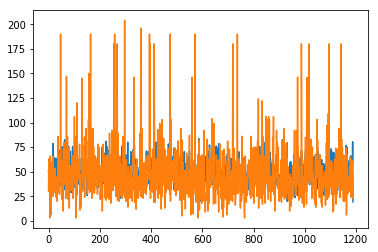

In [0]:
lineareg = LinearRegression(normalize =False)
cross = cross_val_score(lineareg, final_features,pm_final, scoring ='neg_mean_squared_error',cv=3)
x_train, x_test, y_train, y_test = train_test_split(final_features, pm_final, test_size =0.3, random_state =42)

# x_train=map(float,x_train)
# y_train=map(float,y_train)
# x_test=map(float,x_test)
# y_test=map(float,y_test)

lineareg.fit(x_train, y_train)

pred = lineareg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)


#(500 IMAGES LESS THAN WITH THE PREVIOUS REGRESSOR !!!!! )


In [0]:
with open('/content/Linear_withITO_Shanghai.bin','wb') as file:
  pickle.dump(lineareg,file)



In [0]:
print(((-1)*cross)**0.5)

[34.22118463 23.19154146 29.36955672]


In [0]:
d=[]
for i in range(0,len(pred)):
  print(str(y_test[i]) +'\t'+ str(pred[i]))
  k=y_test[i]-pred[i]
  if(k<=20 and k>=-20):
    d.append(k)


30.0	53.751076
63.0	43.763527
40.39	39.978943
40.0	53.912247
44.0	48.130676
46.0	53.72682
3.0	42.38066
66.0	61.48636
52.0	46.959206
6.0	34.56523
44.8	29.900696
26.0	54.50697
45.0	34.28418
35.0	45.371475
60.0	45.733566
57.0	54.17331
44.0	33.289787
25.0	31.542969
65.55	73.53958
32.81	30.794762
42.5	34.63011
49.0	50.01366
41.71	54.30078
45.9	44.853363
29.0	64.78147
29.0	49.70901
53.67	51.59817
42.8	35.3245
43.3	32.324577
27.0	57.789207
24.0	45.157738
29.0	63.48513
42.5	33.33313
20.0	35.48121
45.0	56.130413
36.0	47.253754
46.0	58.90667
85.7	55.586395
28.99	42.008514
47.0	52.995605
66.9	40.0605
33.0	69.4989
44.0	42.56607
27.0	47.888336
41.0	67.504
56.0	44.421173
48.0	45.070442
190.0	62.957626
41.0	67.55225
42.2	35.262344
46.0	53.43198
50.0	43.98227
22.0	77.13183
45.0	43.42099
60.88	74.285416
51.0	59.15733
37.0	39.795586
10.0	58.071716
73.0	54.256084
50.0	41.331924
80.0	75.13615
37.0	33.881393
57.0	41.661606
73.0	79.61445
53.16	42.095245
48.0	70.7713
66.88	73.198105
23.0	50.012707
53.0	35.44

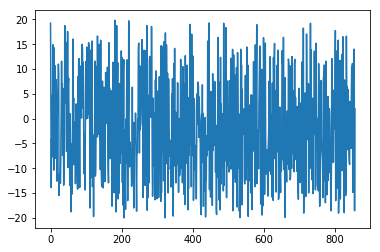

In [0]:
plt.plot(d)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


20.525847869424634


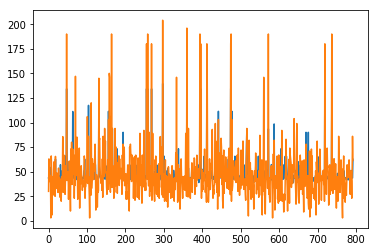

In [0]:
reg = RandomForestRegressor(max_depth=3) 
cross = cross_val_score(reg, final_features, pm_final, scoring ='neg_mean_squared_error',cv=3)
x_train, x_test, y_train, y_test = train_test_split(final_features, pm_final, test_size =0.2, random_state =42)

reg.fit(x_train, y_train)

pred = reg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)


In [0]:
print(((-1)*cross)**0.5)

[33.74768774 30.16778512 30.4844881 ]


In [0]:
#joblib.dump(reg,'Random_withITO.pkl')
with open('/content/Randon_withITO_Shanghai.bin','wb') as file:
  pickle.dump(reg, file)



In [0]:
'''##GETTING NAMES - ITO  ## DONT RUN RIGHT NOW AS THERE IS NO WEATHER DATA FOR THIS 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgito = [] #has all the minote pictures by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name.split('/')[1]=="Lenovo.JPG" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        blob.download_to_filename('/content/' + "ito" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgito.append("ito" + str(blob.name.split('/')[-1])+ '.jpeg') 
        print("ito" + str(blob.name.split('/')[-1])+ '.jpeg')
        ctr+=1
        
        
'''        

'##GETTING NAMES - ITO  ## DONT RUN RIGHT NOW AS THERE IS NO WEATHER DATA FOR THIS \n\nbucket = storage.bucket(app=app)\nblobs = bucket.list_blobs()\n\nimgito = [] #has all the minote pictures by their name \nctr=0\nmits = set()\nfor blob in blobs:\n  if blob.name.split(\'/\')[1]=="Lenovo.JPG" :\n    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:\n        blob.download_to_filename(\'/content/\' + "ito" + str(blob.name.split(\'/\')[-1])+ \'.jpeg\')\n        imgito.append("ito" + str(blob.name.split(\'/\')[-1])+ \'.jpeg\') \n        print("ito" + str(blob.name.split(\'/\')[-1])+ \'.jpeg\')\n        ctr+=1\n        \n        \n'

In [0]:

for i in range(0,len(pred)):
  print(str(y_test[i]) +'\t'+ str(pred[i]))
  
  

In [0]:
def trans_deg(im):
#   im = cv2.imread(img)
#   im = cv2.resize(im, (256,256))
  B=np.zeros((256,256))
  D=np.zeros((256,256))
  C=np.zeros((256,256))
  # 3rd channel or im[2] has been split as b,g,r 

  b,g,r = cv2.split(im)

  for i in range(b.shape[0]):
    for j in range(b.shape[1]):
      D[i][j] = min(b[i][j], g[i][j], r[i][j])
      B[i][j] = max(b[i][j], g[i][j], r[i][j])
      C[i][j] = B[i][j] - D[i][j]

  d = np.sum(D)/float(np.size(D))
  b = np.sum(B)/float(np.size(B))
  c = b-d 
  A = (0.33)*max(np.ndarray.flatten(B)) + (0.66)*b
  
  x1=((A - d)/float(A)) 
  x2=(c/float(A))
  u = 10.127489
  v= -8.336512
  s = 0.13606234
  
  w = math.exp(-0.5*(u*x1 + v*x2)+s)
  
  return w

In [0]:
# def transmission(img, lt = 230, retMean = False):
#   ker = np.ones((3, 3))/9.0
#   imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#   b, g, r = cv2.split(img)
#   hsv = cv2.cvtColor(imgrgb, cv2.COLOR_RGB2HSV)
#   _, _, v = cv2.split(hsv)
#   v_blur = cv2.filter2D(v, -1, ker)
#   _,building_mask = cv2.threshold(v_blur, lt, 255, cv2.THRESH_BINARY)
#   sky = cv2.bitwise_and(imgrgb, imgrgb, mask = building_mask)
#   sky_mask = cv2.bitwise_not(building_mask, building_mask.copy())
#   building = cv2.bitwise_and(imgrgb, imgrgb, mask = sky_mask)
 
#   al = max(v_blur.flatten())
#   #Airlight Found. Now calculate Transmission Map
#   img_norm = img/float(al)
#   b, g, r = cv2.split(img_norm)
#   kernel = np.ones((3,3),np.uint8)
#   im_new = np.zeros((img.shape[0], img.shape[1]))
#   for i in range(img.shape[0]):
#     for j in range(img.shape[1]):
#       im_new[i][j] = min(b[i][j], g[i][j], r[i][j])
#   dcp = cv2.erode(im_new, kernel, iterations = 1)
#   #ax[3].imshow(im_new, cmap = 'gray')
#   #ax[4].imshow(dcp, cmap = 'gray')
#   tr = np.ones((dcp.shape[0], dcp.shape[1]))
#   for i in range(dcp.shape[0]):
#     for j in range(dcp.shape[1]):
#       tr[i][j] = 1 - dcp[i][j]
#   #ax[1].imshow(tr, cmap = 'gray')
#   if retMean == False:
#     return tr
#   elif retMean == True:
#     return np.mean(tr)

In [0]:
def entropy(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  hist = cv2.calcHist( [image.astype('float32')],
              [0], 
              None,
               [256], 
              [0,256] )
  h_norm = 0
  h_norm = cv2.normalize(hist, h_norm)
  ent = 0
  for p in h_norm:
    try:
      ent += p*math.log(p, 2)
    except:
      pass
    
  return (-1 * ent[0])

In [0]:
def contrast(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  s = 0
  ss = 0
  mean = np.mean(image)
  x = (-1 * mean * (np.ones(image.shape)))
  ss = np.square(np.add(image, x))
  cont = np.sqrt(np.sum(ss)/float(image.size))
  return cont

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=120)

cross = cross_val_score(gbrt, features, pm, scoring ='neg_mean_squared_error',cv=3)

x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.2, random_state =42)

gbrt.fit(x_train, y_train)

y_pred = gbrt.predict(x_test)

errors = [mean_squared_error(y_val, y_pred)
for y_pred in gbrt.staged_predict(X_val)]

bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(x_train, y_train) 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

In [0]:
print((cross*(-1))**0.5)

In [0]:
pred = gbrt_best.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)

In [0]:
pred = reg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)

In [0]:
print(((-1)*cross)**0.5)